# IST 736 Text Mining
### HW2 - Vectorization of Social Media Text on AI opinions


Ryan Timbrook (RTIMBROO)  
DATE:10/16/2019<br>
Topic: Sentiment Analysis - AI Trend<br>


## 1. Objective
_____________________________________________________________________________________________
**Goal is to identify the public sentiment toward AI on social media**

Artificial Intelligence (AI) has become a popular topic recently. Assume that you are a consultant at a public relations firm, and a client of your firm would like you to evaluate the current public sentiment toward AI in social media like Facebook and Twitter. 

In this assignment, you will vectorize the data that you collected in HW1. Because the goal is to identify the public sentiment toward AI on social media, you need to think about what vectorization options, regarding both what to count and how to count, would be the best for this goal. Make sure to explain the decisions you made during the vectorization process, e.g., if you removed stopwords and why. 
 
Write a report to include the following information: (1) Briefly recap how you collected the data. (2) Describe your vectorization choices and corresponding result. For example, if you chose to do stemming, how did the vocabulary size change after stemming? Did the stemming eliminate important linguistic information that you'd rather keep, or not? (3) Conclude with the best vectorization option(s). 
 
Your report should provide sufficient information for others to replicate what you did. Submit your report with your original data file and the vectors from your best vectorization options. 


## Findings / Recommendations
place findings and recommendations here  





In [1]:
# toggle for working with colab
isColab = False

In [ ]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [2]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import requests
import os
import string

In [3]:
# packages for twitter
import tweepy as tw
from tweepy import OAuthHandler
import json
from tweepy import Stream
from tweepy.streaming import StreamListener

# packages for NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

import sys
from os import path

In [4]:
# custome python packages
import rtimbroo_utils as br             # custome python helper functions

In [5]:
# set global properties
notebook_file_name = 'hw2_twitter_sentiment_vectorization'
report_file_name = 'HW_2_Timbrook_Ryan'
app_name = 'AI_Public_Sentiment_Vecotorization'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [6]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(dataDir): os.mkdir(dataDir)
if not os.path.exists(configDir): os.mkdir(configDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [7]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name,level=log_level)
np.random.seed(42) # NumPy

## 2. OBTAIN the data   
________________________________________________________________________________________________
Import external dataset created in homework 1
filename = '2019-10-11_ai_tweets.txt'<br>
**Twitter Text Input Format: Individual Tweets are separated by a new line character.
A single tweet text may be on separate lines. Group lines of text as a single tweet if there isn't a blank line separating them.

In [8]:
# get ai tweets from HW1
tweet_filename=f'{dataDir}/2019-10-11_ai_tweets.txt'
with open(tweet_filename,'r') as f:
    ai_tweets = f.readlines()

In [9]:
logger.info(f'Twitter Text - Raw Data Set: Number of lines: {len(ai_tweets)}')

Twitter Text - Raw Data Set: Number of lines: 5743


### 2.1 SCRUB / CLEAN
Perform vectorization tasks

Goal: Identify public sentiment toward AI in social media<br>
Each Tweet is considered an individual document<br>

Determin **what to count** and **how to count it**<br>

Basic text preparation pipeline:

* Load the raw text.
* Split into tokens.
* Convert to lowercase. -> not for sentiment analysis
* Remove punctuation from each token.
* Filter out remaining tokens that are not alphabetic.
* Filter out tokens that are stop words.
* Perform stemming -> [nltk reference](https://pythonprogramming.net/stemming-nltk-tutorial/)

In [10]:
# global variables
initial_words_count = 0
cleaned_words_count = 0
tweets_count = 0
feature_thres = 2
rare_thres = 5

In [11]:
def wordcloud_draw(data, color='black', width=1000, height=750, max_font_size=50, max_words=100):
    words = ' '.join([word for word in data])
    #cleaned_word = " ".join([word for word in words])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                    background_color=color,
                    width=width,
                    height=height,
                    max_font_size=max_font_size,
                    max_words=max_words,
                     ).generate(words)
    plt.figure(1,figsize=(10.5, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [12]:
# raw tweet text has newline characters. this process groups the tweet lines together and indexes the tweet in a dictionary object
tweet_index=0
temp_index=0
tweets_dict = {0:[]}
tweets_sents = []
prior_line_len = 0
current_line_len = 0
next_line_len = 0
max_line_len = len(ai_tweets)

for i, line in enumerate(ai_tweets):
  
    #print(f'line: {i} | Current Tweet Text: {ai_tweets[i]} | Text length: {len(ai_tweets[i])}')
    current_line_len = len(ai_tweets[i])
    
    if i > 0: 
        #print(f'line: {i} | Prior Tweet Text: {ai_tweets[i-1]} | Text length: {len(ai_tweets[i-1])}')
        prior_line_len = len(ai_tweets[i-1])
    
    #print(f'prior_line_len = {prior_line_len} | current_line_len = {current_line_len}')
    
    # next line possible to be in same tweet text
    if (prior_line_len > 1 and current_line_len > 1) or (current_line_len > 1):
        #print(f'In condition 2: prior_line_len > 1 and current_line_len > 1')
        tweets_sents.append(line)
        pass
    
    # questionable if multiple newline spaces show up
    if (current_line_len == 1 and prior_line_len > 1) or (current_line_len == 1 and prior_line_len == 1):
        #print(f'In condition 3: current_line_len == 1 and prior_line_len > 1')

        tweets_dict[tweet_index] = tweets_sents # 
        tweets_sents = []
        # new tweet text
        tweet_index+=1
        pass
    
    #print(f'Tweet:{tweet_index} | text:{line}')
    #if tweet_index > 10: break;
        
len(tweets_dict)

2733

In [13]:
# for each tweet, clean the multiple parts and create one senteces per tweet. this will be the document to tokenize
#tweets_dict
tweets_text_flat = {}

for k,v in tweets_dict.items():
    line = []
    sent = ''
    #print(k)
    #print(v)
    
    for e in v:
        e = e.replace('\n','')
        sent = sent+e
    
    if len(sent) > 1:
        line.append(sent.strip())
        tweets_text_flat[k] = line

#line
tweets_count = len(tweets_text_flat)
logger.info(f'Total Tweets (Documents) Count: {tweets_count}')

Total Tweets (Documents) Count: 2649


**Split Tweet text into it's tokens(feature words) using [NLTK TweetTokenizer](https://www.nltk.org/api/nltk.tokenize.html)**<br>

**Parameters**
* strip_handles=True -> Remove Twitter username handles from text.<br>
* reduce_len=False

Returns<br>
a tokenized list of strings; concatenating this list returns the original string if preserve_case=False

In [14]:
# map tweet to it's tokens
tweets_text_tokens = {}
raw_token_count = 0

for tweet_id,tweet_text in tweets_text_flat.items():
    #print(tweet_text)
    #print(type(tweet_text[0]))
    
    tweetSplitter = TweetTokenizer(strip_handles=True, reduce_len=False) # removes the @tweet_handle
    tweetTokens = tweetSplitter.tokenize(tweet_text[0])
    raw_token_count = raw_token_count+len(tweetTokens)
    
    tweets_text_tokens[tweet_id] = tweetTokens
    #break
#tweets_text_tokens
logger.info(f'Number of Tweet Documents: {len(tweets_text_tokens)}')
logger.info(f'Number of Raw Tokens: {raw_token_count}')


Number of Tweet Documents: 2649
Number of Raw Tokens: 41671


#### INIT FEATURE BoW Count
Perform initial Bag Of Words Count - save off for reference and insights into vocabular size reduction

In [15]:
def count_features(dic,save_as):
    bow = []
    # collect kept feature set after cleaning - and count frequencey
    kept_features = {}
    for tw_id,features in dic.items():
        for word in features:
            bow.append(word)
            if not word in kept_features:
                kept_features[word] = 1
            else:
                word_count = kept_features[word]
                kept_features[word] = word_count+1

    # put the feature word counts into named dictionary and data frame for simpler sorting and observation
    kept_features_named = {'feature':[],'feature_count':[]}
    for feature, count in kept_features.items():
        kept_features_named['feature'].append(feature)
        kept_features_named['feature_count'].append(count)

    # convert dictionary to dataframe for easier sorting
    kept_features_df = pd.DataFrame(kept_features_named)
    kept_features_df_sorted = kept_features_df.sort_values(by=['feature_count','feature'],ascending=False)

    # save df as new data source
    #save_as = f'{dataDir}/tweets_kept_feature_counts.csv'
    kept_features_df_sorted.to_csv(save_as,index=False)

    #kept_features_df_sorted.head()
    
    return kept_features_df_sorted,bow

In [16]:
save_as = f'{dataDir}/tweets_init_feature_counts.csv'
iF = count_features(tweets_text_tokens,save_as=save_as)
bag_of_words = iF[1]
logger.info(f'Initial Bag Of Word Feature Count: {len(bag_of_words)}')
iF[0].head(20)

Initial Bag Of Word Feature Count: 41671


,feature,feature_count
61,…,1230
111,",",910
19,Artificial,813
35,to,781
58,the,777
20,Intelligence,690
117,.,630
88,and,603
14,in,593
3,of,539


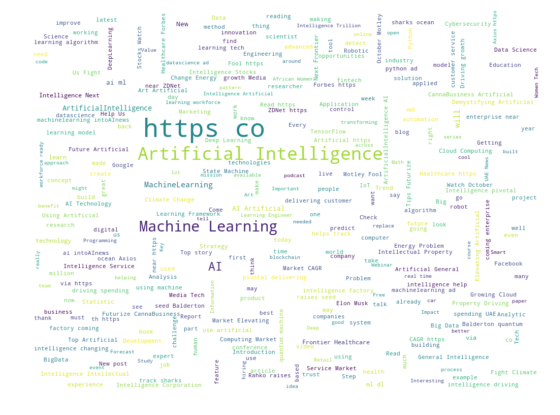

In [17]:
# look at initial word cloud of bag of words
wordcloud_draw(bag_of_words, color='white', max_words=300)

*Cleaning Vocabular Size Reduction* <br>
* Total Tokens Prior To Cleaning: 41671
* Total Tokens After Cleaning: 22262

In [18]:
# parse out hashtags, urls, @xxx, numbers, punctuation from the tweets tokens
def clean_tweet_text(tweets_dic,
                     custom_stop_words=[],
                     remove_pun=True,
                     remove_non_alphabetic=True,
                     remove_stop_words=True,
                     lower_case=False,
                     stemming=False,
                    ):
    tweets_text_hash = {}
    tweets_text_url = {}
    #tweets_text__tokens_cleaned = {}
    total_tokens_prior = 0
    total_tokens_after = 0

    regex_hash=re.compile('^#.+')
    regex_url=re.compile('^http*')


    for tweet_id, tokens in tweets_dic.items():
        tweet_hashes = []
        tweet_urls = []
        tweet_numbers = []
        tweet_non_words = []
        logger.debug(f'tweet: {tweet_id} | feature length prior to text cleaning steps: {len(tokens)}')

        total_tokens_prior = total_tokens_prior+len(tweets_dic[tweet_id])
        #logger.info(f'Total Tokens Prior To Cleaning: {total_tokens_prior}')
        try:
            for t in tokens:
                if((re.match(regex_hash,t))):
                    tweet_hashes.append(t)

                elif((re.match(regex_url,t))):
                    tweet_urls.append(t)

            # remove hash tags
            if len(tweet_hashes) > 0:
                # remove these hash tokens from tweets_text_tokens
                cleaned_tweets_text_tokens = [x for x in tokens if (x not in tweet_hashes)]
                tweets_dic[tweet_id] = cleaned_tweets_text_tokens
                tokens = tweets_dic[tweet_id]
                logger.debug(f'tweet: {tweet_id} | After hash tag removal: {len(tokens)}')

            # remove urls
            if len(tweet_urls) > 0:
                cleaned_tweets_text_tokens = [x for x in tokens if (x not in tweet_urls)]
                tweets_dic[tweet_id] = cleaned_tweets_text_tokens
                tokens = tweets_dic[tweet_id]
                logger.debug(f'tweet: {tweet_id} | After URL removal: {len(tokens)}')

            # remove punctuation
            if remove_pun:
                table = str.maketrans('','',string.punctuation)
                stripped = [w.translate(table) for w in tokens]
                if len(stripped) > 0:
                    tweets_dic[tweet_id] = stripped
                    tokens = tweets_dic[tweet_id]
                    logger.debug(f'tweet: {tweet_id} | After punctuation removal: {len(tokens)}')

            # remove tokens that are not in alphabetic
            if remove_non_alphabetic:
                alpha_words = [word for word in tokens if word.isalpha()]
                if len(alpha_words) > 0:
                    tweets_dic[tweet_id] = alpha_words
                    tokens = tweets_dic[tweet_id]
                    logger.debug(f'tweet: {tweet_id} | After non alphabetic removal: {len(tokens)}')
            
            # lower case
            if lower_case:
                lower_words = [word.lower() for word in tokens]
                tweets_dic[tweet_id] = lower_words
                tokens = tweets_dic[tweet_id]
                #logger.debug(f'tweet: {tweet_id} | After lower case: {len(tokens)}')

            
            # filter out stop words
            if remove_stop_words:
                stop_words = set(stopwords.words('english'))
                new_list = set(list(stop_words) + custom_stop_words)
                not_stop_words = [w for w in tokens if not w in stop_words]
                if len(not_stop_words) > 0:
                    tweets_dic[tweet_id] = not_stop_words
                    tokens = tweets_dic[tweet_id]
                    logger.debug(f'tweet: {tweet_id} | After stop word removal: {len(tokens)}')
            
            # consider stemming...???
            if stemming:
                ps = PorterStemmer()
                stem_words = [ps.stem(word) for word in tokens]
                tweets_dic[tweet_id] = stem_words
                tokens = tweets_dic[tweet_id]
                logger.debug(f'tweet: {tweet_id} | After stemming: {len(tokens)}')
            
            # count tokens
            total_tokens_after = total_tokens_after+len(tweets_dic[tweet_id])
            
        except BaseException as be:
            logger.warning(f'**WARNING** Caught BaseException: {be}')
            pass

    logger.info(f'Total Tokens Prior To Cleaning: {total_tokens_prior}')
    logger.info(f'Total Tokens After Cleaning: {total_tokens_after}')
    
    
    return tweets_dic,tweets_text_hash,tweets_text_url

#### KEPT FEATURES BoW Count
Perform word frequency count for kept feature list

In [19]:
tw_clean = clean_tweet_text(tweets_text_tokens,
                     custom_stop_words=[],
                     remove_pun=True,
                     remove_non_alphabetic=True,
                     remove_stop_words=True,
                     lower_case=True,
                     stemming=False,
                    )


Total Tokens Prior To Cleaning: 41671
Total Tokens After Cleaning: 19841


In [20]:
tw_kept_feats = tw_clean[0]
tw_hash = tw_clean[1]
tw_url = tw_clean[2]

In [21]:
# save tweets as csv
# put the feature word counts into named dictionary and data frame for simpler sorting and observation
kept_tweet_features = {'tweet_id':[],'features':[]}
for tweet_id, features in tw_kept_feats.items():
    kept_tweet_features['tweet_id'].append(tweet_id)
    kept_tweet_features['features'].append(features)

# convert dictionary to dataframe for easier sorting
kept_tweet_features_df = pd.DataFrame(kept_tweet_features)
kept_tweet_features_df_sorted = kept_tweet_features_df.sort_values(by=['tweet_id'],ascending=True)

# save df as new data source
save_as = f'{dataDir}/tweets_kept_features.csv'
kept_tweet_features_df_sorted.to_csv(save_as,index=False)

In [22]:
save_as = f'{dataDir}/tweets_kept_lower_feature_counts.csv'
kf = count_features(tw_kept_feats,save_as=save_as)
clean_bag_of_words = kf[1]
kf[0].head(20)

,feature,feature_count
10,artificial,1128
11,intelligence,1097
3,learning,766
2,machine,733
136,ai,324
66,data,147
84,via,132
8,new,105
232,top,100
242,market,99


In [ ]:
#clean_bag_of_words

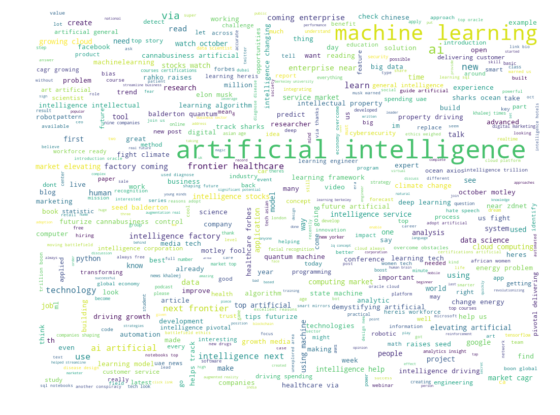

In [23]:
# look at cleaned word cloud of bag of words
wordcloud_draw(clean_bag_of_words, color='white', max_words=500)

In [24]:
# get tweet feature files
#kept_feats_file = 'tweets_kept_feature_counts.csv'
kept_feats_file = 'tweets_kept_lower_feature_counts.csv'
#kept_feats_file = 'tweets_kept_lower_stem_feature_counts.csv'
kept_tweet_feats_file = 'tweets_kept_features.csv'

kept_feats_counts = pd.read_csv(f'{dataDir}/{kept_feats_file}',error_bad_lines=False, encoding = "ISO-8859-1")
kept_tweet_feats = pd.read_csv(f'{dataDir}/{kept_tweet_feats_file}',error_bad_lines=False, encoding = "ISO-8859-1")
#kept_feats_counts.head()
kept_tweet_feats.head()

,tweet_id,features
0,0,"['rare', 'form', 'machine', 'learning', 'spot'..."
1,1,"['new', 'post', 'artificial', 'intelligence', ..."
2,2,"['toyotas', 'lq', 'concept', 'introduces', 'he..."
3,3,"['heavy', 'rotation', 'interpretbank', 'autumn']"
4,4,"['improving', 'hundreds', 'small', 'details', ..."


In [25]:
# save off each tweet as it's own file
import io
for row in kept_tweet_feats.iterrows():
    tweet_id = row[1]['tweet_id']
    features = row[1]['features']
    features = features.replace('[','')
    features = features.replace(']','')
    features = features.replace('\'','')
    features = features.replace(',','')
    
    with io.open(f'{corpusDir}/{tweet_id}_ai_tweet_text.txt','w+',encoding='utf8') as f:
        f.write(features)

### 3. Vectorization Models


In [26]:
#create integer feature vector mappings
feature_id_map = {}
id_feature_map = {}

feats = kept_feats_counts.feature

for i,f in enumerate(feats):
    id_feature_map[i] = f
    feature_id_map[f] = i

In [27]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from time import time
import shorttext
#from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


[sklearn CountVectorizer](https://scikit-learn.org/0.15/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)<br>
Convert a collection of text documents to a matrix of token counts<br>

This implementation produces a sparse representation of the counts using scipy.sparse.coo_matrix.<br>

If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data<br>

In text mining, it is important to create the document-term matrix (DTM) of the corpus we are interested in. A DTM is basically a matrix, with documents designated by rows and words by columns, that the elements are the counts or the weights (usually by tf-idf). Subsequent analysis is usually based creatively on DTM.<br>

CountVectorizer supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices:<br>
The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.<br>

In [28]:
# get tweet files from path
tweet_files = []
tweet_filenames = {}

path=f'{corpusDir}/'
for dirpath, dirs, files in os.walk(path):
    #print(dirpath)
    #print(dirs)
    #print(files)
    for i,f in enumerate(files):
        tweet_files.append(dirpath+f)
        tweet_filenames[i] = f
#tweet_files

In [30]:
tweet_files[:5]

['./corpus/0_ai_tweet_text.txt',
 './corpus/1000_ai_tweet_text.txt',
 './corpus/1001_ai_tweet_text.txt',
 './corpus/1002_ai_tweet_text.txt',
 './corpus/1003_ai_tweet_text.txt']

In [31]:
# test CountVectorizer from sklearn
count_vectorizer = CountVectorizer(input='filename',
                                   #ngram_range=(1,1),
                                   #max_df=1.0,
                                   #min_df=0.001,
                                   stop_words='english',
                                   max_features=None)

In [33]:
#Returns:	
#X : array, [n_samples, n_features]
fit_vec = count_vectorizer.fit(tweet_files)

In [61]:
#logger.info(f'CountVectorizer Fit: \n{fit_vec.vocabulary_}')
voc_dict = dict(fit_vec.vocabulary_)
voc_df = pd.DataFrame.from_dict(voc_dict, orient='index').reset_index()
voc_df.columns=('feature','feature_count')
voc_df.sort_values(by='feature_count', ascending=False)[::10].head(20)

,feature,feature_count
3540,zoomcar,4720
2857,youve,4710
2418,yield,4700
2259,yape,4690
1610,wsj,4680
2831,wow,4670
3345,workshopfree,4660
610,work,4650
1365,wonder,4640
2635,witho,4630


In [54]:
voc_df.feature_count.describe()

count    4721.00000
mean     2360.00000
std      1362.97964
min         0.00000
25%      1180.00000
50%      2360.00000
75%      3540.00000
max      4720.00000
Name: feature_count, dtype: float64

In [62]:
tdm_vec = fit_vec.transform(tweet_files)

In [40]:
logger.info(f'CountVectorizer TDM shape:{tdm_vec.shape}')
logger.info(f'CountVectorizer TDM size:{tdm_vec.size}')
logger.info(f'CountVectorizer TDM type:{type(tdm_vec)}')
logger.info(f'CountVectorizer TDM toarray:{type(tdm_vec.toarray())}')

CountVectorizer TDM shape:(2649, 4721)
CountVectorizer TDM size:18124
CountVectorizer TDM type:<class 'scipy.sparse.csr.csr_matrix'>
CountVectorizer TDM toarray:<class 'numpy.ndarray'>


In [41]:
word_id_map = {}
id_word_map = {}

words = fit_vec.get_feature_names()
logger.debug(words)

for i,f in enumerate(words):
    word_id_map[i] = f
    id_word_map[f] = i

In [42]:
words

['abi',
 'abila',
 'abilities',
 'ability',
 'able',
 'abominable',
 'abou',
 'absolute',
 'abstraction',
 'abstractive',
 'academ',
 'academy',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accenture',
 'accept',
 'accessible',
 'accidents',
 'accolades',
 'according',
 'accounted',
 'accounting',
 'accra',
 'acct',
 'accuracies',
 'accuracy',
 'accurate',
 'accurately',
 'achievable',
 'achieve',
 'achieved',
 'achieving',
 'acl',
 'acquire',
 'acquired',
 'act',
 'action',
 'actions',
 'activated',
 'activities',
 'actual',
 'actually',
 'actuators',
 'ad',
 'adaboost',
 'adage',
 'adam',
 'adapt',
 'adapting',
 'adaptive',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'additive',
 'address',
 'addresses',
 'admi',
 'administrative',
 'admiration',
 'adolfsson',
 'adopt',
 'adopted',
 'adoption',
 'ads',
 'advance',
 'advanced',
 'advancement',
 'advancements',
 'advances',
 'advantage',
 'advantages',
 'adversarial',
 'adversaries',
 'advertisers',
 'a

In [71]:
cols = fit_vec.get_feature_names()
tdm_vec_df = pd.DataFrame(tdm_vec.toarray(),columns=cols)
non_zero_field_count = 0
# output feature vector term frequence vector as 'doc feature frequency'
with open(f'{dataDir}/feature_vector_tf.txt','w+') as f:

    for i in range(0,tdm_vec_df.shape[0]):
        a = [index for index,value in enumerate(tdm_vec_df.iloc[i]) if value > 0]
        sent = tweet_filenames[i]
        non_zero_field_count = non_zero_field_count+len(a)
        
        for col in a:
            v = tdm_vec_df.iloc[i,col]
            sent = sent+' '+word_id_map[col]+' '+str(v)
        
        f.write(sent+'\n')

In [68]:
tdm_vec_df[::100].head()

,abi,abila,abilities,ability,able,abominable,abou,absolute,abstraction,abstractive,...,yui,yyc,zach,zdnet,zeeshan,zero,zest,zimbabwe,zomato,zoomcar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
(2649*4721)*4

50023716

In [44]:
test = [558, 1699, 1913, 2457, 2572, 3411, 3938]
for i in test:
    print(word_id_map[i])

broken
form
hackers
learning
machine
rare
spot


[sklearn TfidfVectorizer](https://scikit-learn.org/0.15/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)<br>

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.<br>

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.<br>

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.<br>

Both tf and tf–idf can be computed as follows using TfidfTransformer:<br>

In [77]:
# test TfidfVectorizer from sklearn - 
tfidf_vectorizer = TfidfVectorizer(input='filename',smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
idf_vec = tfidf_vectorizer.fit(tweet_files)
tfidf_vec = idf_vec.transform(tweet_files)

In [78]:
idf_feat_names = idf_vec.get_feature_names()


In [79]:
#idf_vec.vocabulary_
idf = tfidf_vectorizer.idf_
idf_weights = dict(zip(idf_vec.get_feature_names(), idf))
logger.info(idf_weights)
#idf_weights_df = pd.DataFrame(idf_weights)
#idf_weights_df.head()

{'abi': 8.881937489272069, 'abila': 8.881937489272069, 'abilities': 8.188790308712125, 'ability': 7.272499576837969, 'able': 7.495643128152179, 'abominable': 8.881937489272069, 'abou': 8.188790308712125, 'absolute': 8.188790308712125, 'abstraction': 8.881937489272069, 'abstractive': 8.881937489272069, 'academ': 8.881937489272069, 'academy': 7.495643128152179, 'accelerant': 8.881937489272069, 'accelerate': 8.188790308712125, 'accelerated': 8.881937489272069, 'accelerates': 8.881937489272069, 'accenture': 7.78332520060396, 'accept': 8.881937489272069, 'accessible': 7.78332520060396, 'accidents': 8.188790308712125, 'accolades': 8.881937489272069, 'according': 7.495643128152179, 'accounted': 8.881937489272069, 'accounting': 8.881937489272069, 'accra': 8.881937489272069, 'acct': 8.881937489272069, 'accuracies': 8.881937489272069, 'accuracy': 7.495643128152179, 'accurate': 6.8024959475922335, 'accurately': 8.188790308712125, 'achievable': 7.78332520060396, 'achieve': 8.188790308712125, 'achi

In [80]:
# graph inverse document frequency
token_weight = pd.DataFrame.from_dict(idf_weights, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight.head()

,token,weight
0,abi,8.881937
2809,misty,8.881937
2788,mimic,8.881937
2790,minding,8.881937
2792,mindset,8.881937


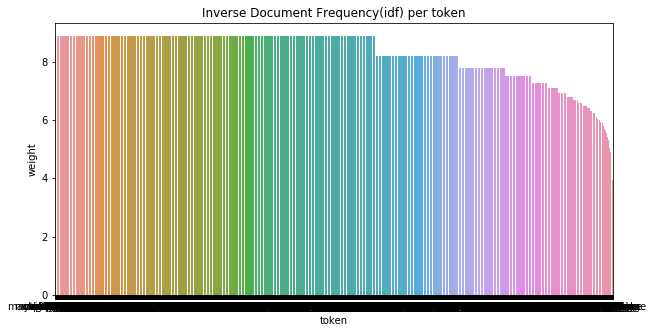

In [81]:
#graph inverse document frequency
sns.barplot(x='token', y='weight', data=token_weight)            
plt.title("Inverse Document Frequency(idf) per token")
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

In [82]:
# Listing inverse document frequency
# get feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names())
sorted_by_idf = np.argsort(tfidf_vectorizer.idf_)
logger.info("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:3]]))
logger.info("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-3:]]))

Features with lowest idf:
['artificial' 'intelligence' 'learning']

Features with highest idf:
['hinton' 'heterogeneous' 'zoomcar']


**Weight of tokens per document**<br>
the more times a token appears in a document, the more weight it will have. However, the more documents the token appears in, it is 'penalized' and the weight is diminished. For example, the weight for token 'not' is 4, but if it did not appear in all documents (that is, only in one document) its weight would have been 8.3

In [83]:
print("The token 'not' has  the largest weight in document #2 because it appears 3 times there. But in document #1\
 its weight is 0 because it does not appear there.")
tfidf_vec.toarray()

The token 'not' has  the largest weight in document #2 because it appears 3 times there. But in document #1 its weight is 0 because it does not appear there.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**TF-IDF - Maximum token value throughout the dataset**

In [84]:
new_tf = idf_vec.transform(tweet_files)

# find maximum value for each of the features over all of dataset:
max_val = new_tf.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:3]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-3:]]))

Features with lowest tfidf:
['artificial' 'intelligence' 'via']

Features with highest tfidf: 
['azure' 'phil' 'fellowship']
